# MEFISTO application to spatial transcriptomics

This notebook demonstrates how MEFISTO can be applied to spatial transcriptomics using its interface for muon.

R vignette for this application [is available here](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/MEFISTO_ST.html#7_SessionInfo).

We use the `"Mouse Brain Serial Section 1 (Sagittal-Anterior)"` dataset [provided by 10X Genomics](https://support.10xgenomics.com/spatial-gene-expression/datasets).
The following files are used in this tutorial:

- _Feature / cell matrix HDF5 (filtered)_ (`filtered_feature_bc_matrix.h5`),
- _Spatial imaging data_ (`spatial.tar.gz`, has to be unarchived).

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import muon as mu

In [2]:
# Set the working directory to the root of the repository
import os
os.chdir("../")

## Load data

In this notebook, we put the files mentioned above into the `data/ST/` directory.

In [3]:
datadir = "data/ST/"

In [4]:
adata = sc.read_visium(datadir)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata

AnnData object with n_obs × n_vars = 2695 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## QC and preprocessing

We will follow [scanpy's spatial tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html) for the steps below.

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<AxesSubplot:xlabel='n_genes_by_counts'>

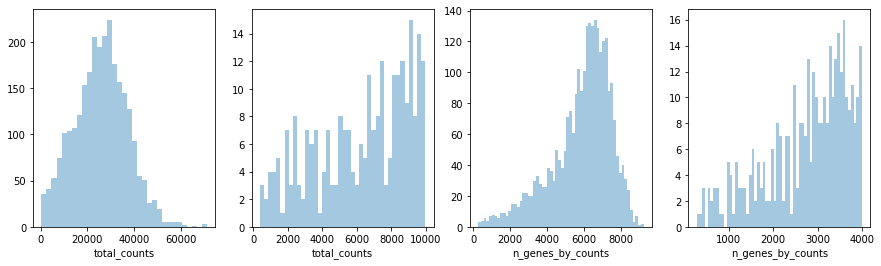

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [8]:
mu.pp.filter_obs(adata, 'total_counts', lambda x: x < 50000)
mu.pp.filter_obs(adata, 'pct_counts_mt', lambda x: x < 20)
mu.pp.filter_var(adata, 'n_cells_by_counts', lambda x: x > 10)

In [9]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


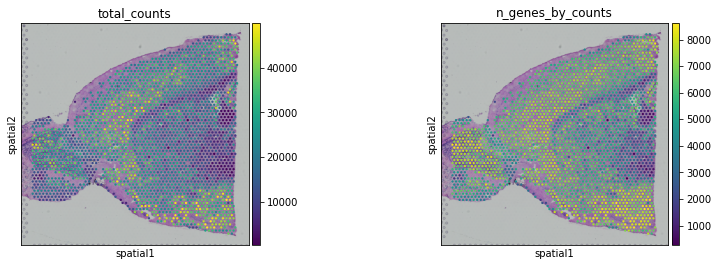

In [10]:
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

We will now add spatial covariates to the `.obs` slot so that we can refer to them easily later:

In [11]:
adata.obs = pd.concat([adata.obs, 
                       pd.DataFrame(adata.obsm["spatial"], columns=["imagerow", "imagecol"], index=adata.obs_names),
                      ], axis=1)

## Train a MEFISTO model

In [12]:
# We use 1000 inducing points to learn spatial covariance patterns
n_inducing = 1000

In [13]:
mu.tl.mofa(adata, n_factors=4, 
           smooth_covariate=["imagerow", "imagecol"],
           smooth_kwargs={
               "sparseGP": True, "frac_inducing": n_inducing/adata.n_obs, 
               "start_opt": 10, "opt_freq": 10,
           },
           outfile="models/mefisto_ST.hdf5",
           use_float32=True, seed=2021,
           quiet=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
use_float32 set to True: replacing float64 arrays by float32 arrays to speed up computations...

Loaded view='rna' group='group1' with N=2448 samples and D=2000 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab pri

## Downstream analyses

For some of the functionality below we will also use [mofax](https://github.com/gtca/mofax).

In [14]:
import mofax
m = mofax.mofa_model("models/mefisto_ST.hdf5")

### Factors correlation

First, we can take a look whether our factor are uncorrelated.

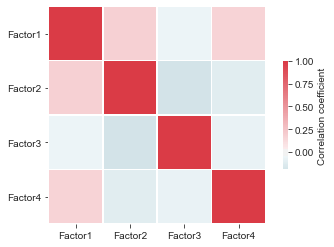

In [15]:
mofax.plot_factors_correlation(m);

### Spatial factors

We will then have a look at the spatial patterns that are captured by each factor. 

In [16]:
for i in range(4):
    adata.obs[f"Factor{i+1}"] = adata.obsm["X_mofa"][:,i]

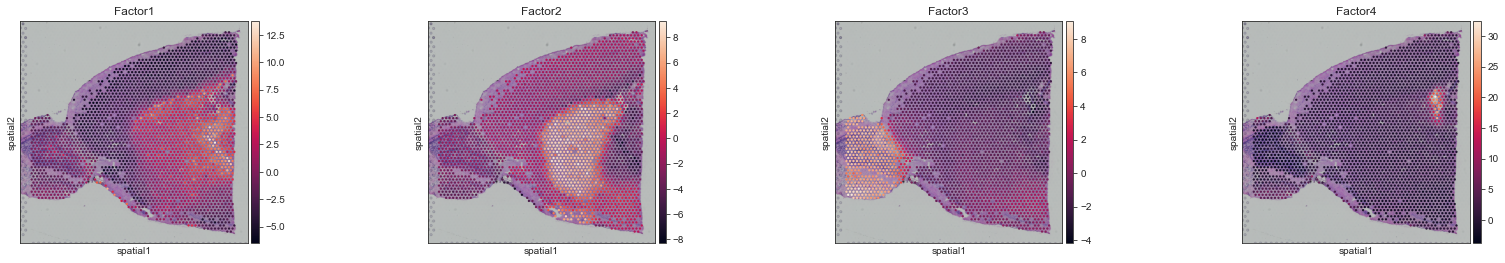

In [17]:
sc.pl.spatial(adata, img_key="hires", color=[f"Factor{i+1}" for i in range(4)])

### Smoothness of factors

All of this factors seem to capture spatial patterns of variation that seems to vary smoothly along space to some extent. We can take a look at the smoothness score inferred by the model.

<AxesSubplot:xlabel='Smoothness', ylabel='Factor'>

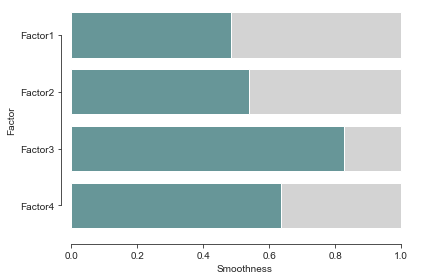

In [18]:
mofax.plot_smoothness(m)

### Weights

We will take `Factor4` as an example to show the spatial expression pattern for genes that have the highest weights for that factor.

In [19]:
top_features_f4 = m.get_top_features(factors="Factor4", n_features=3)
top_features_f4

array(['Ttr', 'Enpp2', 'Igfbp2'], dtype=object)

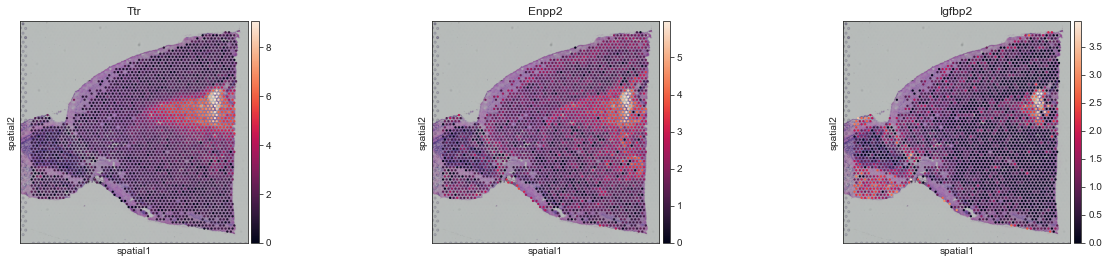

In [20]:
sc.pl.spatial(adata, img_key="hires", color=top_features_f4)